# Semantic Dataset Comparison using CLIP

## Introduction
In this project, I tried to understand how two image datasets can be compared semantically instead of just looking at pixels.  
I used CLIP because it can understand the meaning behind images, not just colors or shapes.  

I did two experiments:  
1. CIFAR-10: compare Dog vs Cat and Cat vs Truck  
2. CIFAKE: compare real vs fake images  

Also, I visualized embeddings using t-SNE for CIFAR-10 to see how the classes are separated.  

---

## Step 1: Setup and Imports

In [1]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import CLIPProcessor, CLIPModel

## Step 2: Load the CLIP Model

In this step, we load the **CLIP (Contrastive Language–Image Pre-training)** model.

**Why I used CLIP for semantic dataset comparison?**
 Because CLIP can understand the content of an image without being explicitly trained on specific categories within our datasets (like 'dog', 'cat', or 'truck' for CIFAR-10, or 'real'/'fake' for CIFAKE).

When we use CLIP, we get a numerical representation (an **embedding**) for each image. Images that are semantically similar (i.e., have similar meaning or content) will have embeddings that are close to each other in a high-dimensional space. By comparing the embeddings of images from different datasets or different classes within a dataset, we can measure their **semantic similarity**. This is a much better comparison than just looking at pixel values.

We load two main components:
- `CLIPModel`: This is the core neural network.
- `CLIPProcessor`: This tool helps us prepare our images (and text, though we primarily use images here) in the correct format and size that the CLIP model expects.

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Step 3: Load CIFAR-10 Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP needs 224x224 images
    transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
class_to_idx = dataset.class_to_idx
print("Classes:", class_to_idx)

Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


We will compare:
*  Dog vs Cat
*  Cat vs Truck

In [4]:
dog_idx = class_to_idx['dog']
cat_idx = class_to_idx['cat']
truck_idx = class_to_idx['truck']

dog_subset = [i for i, (_, label) in enumerate(dataset) if label == dog_idx]
cat_subset = [i for i, (_, label) in enumerate(dataset) if label == cat_idx]
truck_subset = [i for i, (_, label) in enumerate(dataset) if label == truck_idx]

## Step 4: Function to Get Embeddings

In [53]:
def get_embeddings(dataset, indices, model, processor, max_images=1000):
    subset = Subset(dataset, indices[:max_images])  # limit images for speed
    loader = DataLoader(subset, batch_size=32, shuffle=False)
    embeddings = []

    for images, i in tqdm(loader):
        inputs = processor(images=images, return_tensors="pt")
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # normalize
        embeddings.append(image_features.cpu())

    return torch.cat(embeddings, dim=0)

## Step 5: Compute Dataset Similarity

This code block defines the `dataset_similarity` function. Its purpose is to quantify how semantically similar two entire sets of images are, based on their CLIP embeddings.

Here, we use **Cosine Similarity**.

**Cosine Similarity** measures the cosine of the angle between two vectors in a multi-dimensional space.

In [54]:
def dataset_similarity(emb1, emb2):
    sim_matrix = cosine_similarity(emb1, emb2)
    return np.mean(sim_matrix)

## Step 6: CIFAR-10 Experiments

* Dog vs Cat

In [55]:
dog_emb = get_embeddings(dataset, dog_subset, model, processor)
cat_emb = get_embeddings(dataset, cat_subset, model, processor)

sim_dog_cat = dataset_similarity(dog_emb, cat_emb)
print("Semantic Similarity (Dog vs Cat):", sim_dog_cat)

100%|██████████| 32/32 [01:45<00:00,  3.28s/it]

Semantic Similarity (Dog vs Cat): 0.9994825


### Cat vs Truck Comparison

Next, we compare the semantic similarity between 'cat' images and 'truck' images from the CIFAR-10 dataset. This pair represents two categories that are intuitively very different semantically (an animal vs. a vehicle).

**Interpretation and Comparison:**

The output shows "Semantic Similarity (Cat vs Truck): 0.99936706".

Comparing this to the **Dog vs Cat similarity score of 0.9994825**:

- The Cat vs Truck similarity score (0.99936706) is **slightly lower** than the Dog vs Cat score (0.9994825).

Although both scores are very high (close to 1), this maybe because, i just considered 1000 samples for better speed.

In [8]:
truck_emb = get_embeddings(dataset, truck_subset, model, processor)

sim_cat_truck = dataset_similarity(cat_emb, truck_emb)
print("Semantic Similarity (Cat vs Truck):", sim_cat_truck)

100%|██████████| 32/32 [01:36<00:00,  3.01s/it]

Semantic Similarity (Cat vs Truck): 0.99936706


## Step 7: t-SNE Visualization for CIFAR-10

t-SNE is a popular **dimensionality reduction technique**. Our CLIP image embeddings are high-dimensional vectors (meaning they have many, perhaps hundreds or thousands, of components). Our brains can't easily visualize data in such high dimensions. t-SNE takes this high-dimensional data and creates a representation of it in a lower-dimensional space, typically 2D or 3D, which we can then plot.

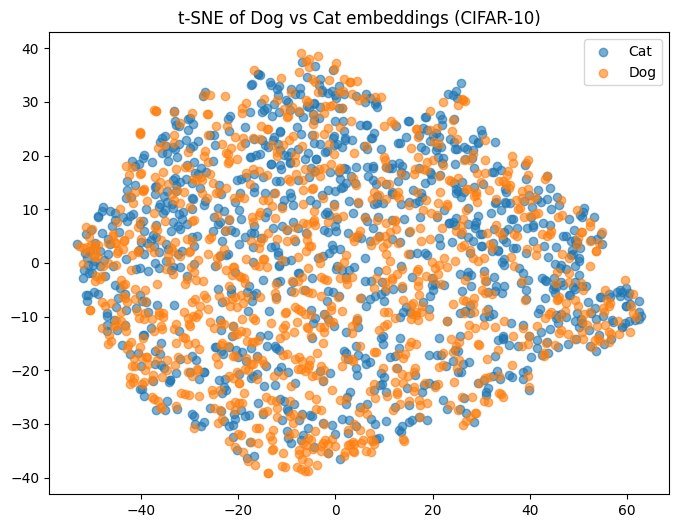

In [10]:
# Combine Dog and Cat embeddings for visualization
emb_combined = torch.cat([dog_emb, cat_emb], dim=0).numpy()
labels = ['Dog'] * dog_emb.shape[0] + ['Cat'] * cat_emb.shape[0]

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_combined)

plt.figure(figsize=(8,6))
for lbl in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == lbl]
    plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=lbl, alpha=0.6)
plt.legend()
plt.title("t-SNE of Dog vs Cat embeddings (CIFAR-10)")
plt.show()

## t-SNE Visualization of Truck vs Cat

here, you can see that the Truck and Cat datapoints and create or almost creating two different clusters , signifying that there is lesser similarty between the Truck and Cat datasets.

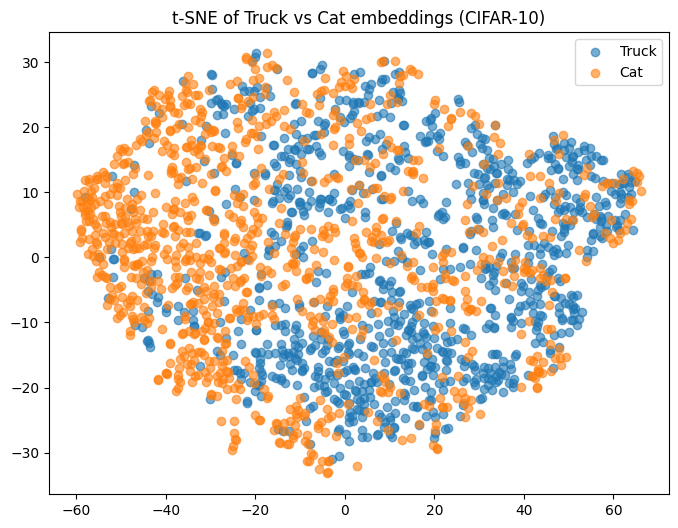

In [11]:
# Combine Truck and Cat embeddings for visualization
emb_combined = torch.cat([truck_emb, cat_emb], dim=0).numpy()
labels = ['Truck'] * truck_emb.shape[0] + ['Cat'] * cat_emb.shape[0]

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_combined)

plt.figure(figsize=(8,6))
for lbl in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == lbl]
    plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=lbl, alpha=0.6)
plt.legend()
plt.title("t-SNE of Truck vs Cat embeddings (CIFAR-10)")
plt.show()